# Auto Fringe Tracing - Fourier

Template originally written by Jack Hare (updated by Thomas Varnish, 2020)

Start by loading the relevant libraries. (We call `%matplotlib notebook` to ensure all the plots are interactive.)

In [ ]:
# Uncomment if you don't have magpie_tools/code in your PYTHONPATH
# import sys
# sys.path.append("C:\\Users\\User\\Documents\\magpie_tools\\code")

In [1]:
%matplotlib notebook

from fringe_tracing_fourier import *
from skimage.filters import gaussian
import imageio

import fringe_tracing_smoothing as ft  # Loaded for: save_file, save_file_alpha, load_file, plot_compare

## Load up the interferograms
On Windows, you can Shift + Right-Click a folder and choose "Copy as Path". Enter the path where the interferogram images are stored (into the `%cd` command).

We start with the background because it gives us good default values for the shot interferogram.

Copy the interferogram file name into `interferogram_fn`. 

Next, we load the interferogram and convert it to grayscale.

In [2]:
%cd "C:\Users\Thomas\Files\Magpie\_data\s0823_18 Plasma Gun TS\532 nm interferometry"

interferogram, interferogram_fn = ft.load_file("g20 bk.jpg")

C:\Users\Thomas\Files\Magpie\_data\s0823_18 Plasma Gun TS\532 nm interferometry


### Normalise the interferogram
We correct for variations in brightness by dividing the interferogram by a blurred version of itself. Choose the smallest value for blur such that no fringes are visible - it will be around the width of two fringes in pixels.

The blurred interferogram gives us (most of) the slowly varying, low frequency noise. Essentially, we're applying a high pass filter to the image before we proceed with extracting the fringes.

Make sure to zoom in on the blurred image to ensure there aren't any fringes visible.

<IPython.core.display.Javascript object>


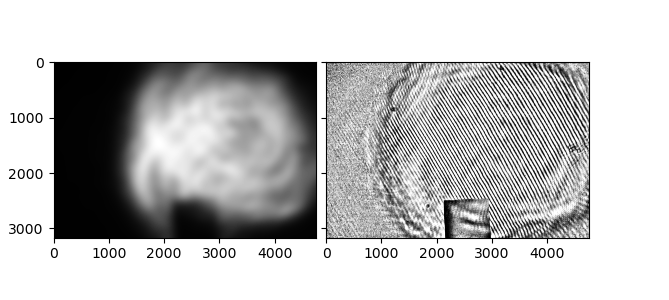

(<matplotlib.image.AxesImage at 0x2978ee7efd0>,
 <matplotlib.image.AxesImage at 0x2978ee912b0>)

In [3]:
blur = 80

blurred_interferogram = gaussian(interferogram, blur)
normalised_interferogram = interferogram / blurred_interferogram

clip = [0.3, 1.2]
clipped_interferogram = (np.clip(normalised_interferogram, a_min=clip[0], a_max=clip[1])-clip[0])/(clip[1]-clip[0])

fig = plt.figure(figsize=(6.69, 3))
ft.plot_compare(fig, blurred_interferogram, clipped_interferogram)

#### Saving the clipped Interferogram
Enter the path where you want to store the clipped interferogram (for reference when tracing any missed fringes), and any processed data. This should probably be in a different location to where the raw interferograms are stored.

In [4]:
%cd "C:\Users\Thomas\Files\Magpie\analysis\demo"

ft.save_file(interferogram_fn + " enhanced", clipped_interferogram)

C:\Users\Thomas\Files\Magpie\analysis\demo


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


### Taking the FFT of the Interferogram
Once you're happy with the blurred interferogram, check out the Fourier transform of the normalised interferogram. Zoom in on the centre of the image - there should be two blobs on opposite sides of the central point. These contain the information about the predominant fringe pattern, and we'll get rid of all the other data.

These blobs (two because it's a real FFT) represent the frequency of the fringes which are (almost) evenly spaced (especially in the background interferogram). Therefore, the frequency is almost a single frequency (like a sin/cos), and we want to isolate this, removing any noise (both high frequency like the small blotches in the interferogram, and low frequency, like the larger slowly varying structures we tried to remove with the normalisation stage).

For reference, a polar grid (rings spaced radially by 10, and radial lines spaced by 10 degrees) is placed on top of the FFT image. You can use this to estimate the parameters needed for the filter.

<IPython.core.display.Javascript object>


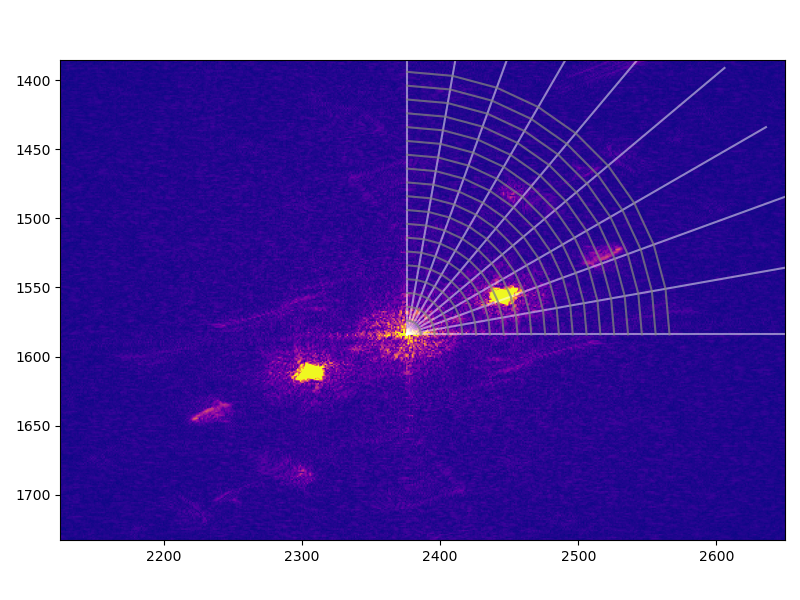

In [6]:
fft_image = (np.fft.fftshift(np.fft.fft2(normalised_interferogram)))

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(abs(fft_image), cmap="plasma", clim=[0, 100000])


# Draw the polar reference grid on top of the FFT image
y_size, x_size = fft_image.shape
mid_x, mid_y = x_size / 2.0, y_size / 2.0

for angle in range(0, 100, 10):
    R = 300
    dx, dy = R * np.cos(angle * np.pi/180.0), R * np.sin(angle * np.pi/180.0)
    ax.plot([mid_x, mid_x + dx], [mid_y, mid_y - dy], '-', color="white", alpha=0.5)
    
for r in range(10, 200, 10):
    line_x = []
    line_y = []
    for angle in range(0, 100, 10):
        dx, dy = r * np.cos(angle * np.pi/180.0), r * np.sin(angle * np.pi/180.0)
        line_x.append(mid_x + dx)
        line_y.append(mid_y - dy)
    ax.plot(line_x, line_y, '-', color="gray", alpha=0.75)
    
fig.tight_layout()

### Select a region from the Fourier image
Use the sliders below to select the important parts of the Fourier image. The mask consists of two circles at a distance R_0 from the centre, at an angle of theta to the vertical. Each circle has a radius of 'Radius of filter' and the edges can be smoothed slightly with 'Filter blur' to prevent hard edges causes artefacts after the inverse Fourier transform happens.

In general, you want the smallest circles that are centered on the two bright spots in the Fourier image, with a little blur (eg. 20% of the filter radius).

Note: the angle `theta` is measured from the vertical, going clockwise. `R0` is measured from the central FFT point. See the previous plot shows an overlaid quadrant of these polar coordinates. Each line (increasing `theta`) represents 10 degrees. Each ring (increasing `R0`) represents 10 (pixels).

If you type values into the sliders (by clicking on the numerical value), make sure to press enter after each change. Only one slider value can be changed at once (i.e. you can't change all the values and then press enter on the last one; that will only update the change of the last slider).

In [7]:
w1=interactive(plot_filter, 
               fft=fixed(fft_image), R0=R0, theta=theta, 
               radius_of_filter=radius_of_filter, blur=blur_edges)
display(w1)

interactive(children=(IntSlider(value=100, continuous_update=False, description='R_0:', max=200, step=5), IntS…

### Create the Fourier-filtered Interferogram
Once you're happy with the region of Fourier space you're keeping in the above cell, it's time to do the inverse Fourier transform and look at the resulting interferogram.
This interferogram will only contain fringes aligned with the predominant fringe pattern, and it doesn't include the high frequency modulations seen in the beam.

<IPython.core.display.Javascript object>


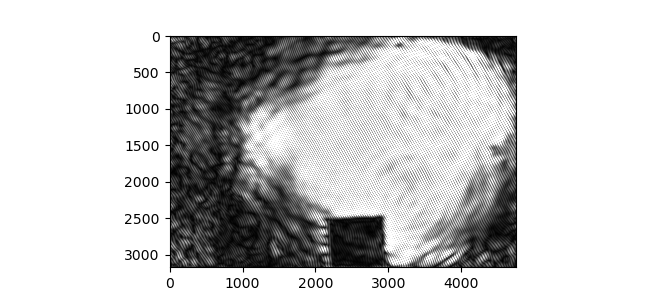

In [10]:
# Filter the FFT image using the paramters chosen above
a, fft_filter = create_filter(**w1.kwargs)
masked_fft = fft_filter * fft_image

# Take the inverse FFT of the filtered FFT image
ifft_image = abs((np.fft.ifft2(masked_fft)))

fig, ax = plt.subplots(figsize=(6.69, 3))
ax.imshow(ifft_image, cmap='gray', clim=[0, 0.4])

### Threshold the filtered image
Now we need to conver this interferogram to a binary black or white image. Then an algorithm reduces these black and white fringes to one pixel thick lines for Magic2.

First, change a threshold so it is approximately the value halfway between a dark and a bright fringe - something like 0.1-0.3 usually works. Then run the cell. A PNG file will be created in the processed data folder (where the enhanced interferogram is saved), with the same file name + 'traced'.

Zoom in on the traced interferogram plot and inspect it. If the fringes don't extend as far as you'd like, then decrease the threshold value. If the fringes are joined by short perpendicular fringes, increase the threshold value. Keep editing the threshold value and running this cell until you're happy with the result.

C:\Users\Thomas\Files\Magpie\analysis\demo


<IPython.core.display.Javascript object>


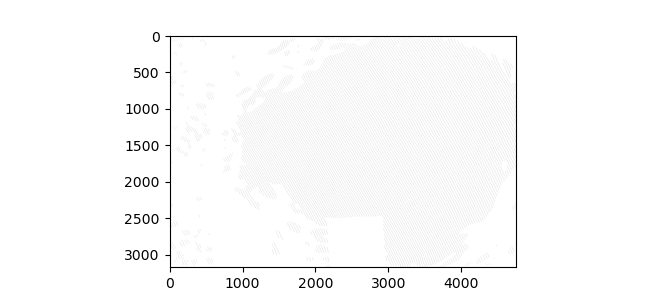

In [11]:
%cd "C:\Users\Thomas\Files\Magpie\analysis\demo"

threshold_value = 0.2

bwimage = ifft_image > threshold_value
imthin = thin(bwimage, max_iter=1000)
invert = 1 - imthin

fig, ax = plt.subplots(figsize=(6.69, 3))
ax.imshow(invert, cmap="gray")

#### Save the traced interferogram file
Again, enter the path where you want to store the traced interferogram (in `%cd`).

To convert the black-and-white image to a black-and-transparent image, we set all white values to False (transparent when using `save_file_alpha`) and then invert the image to ensure the lines are black not white.

In [12]:
%cd "C:\Users\Thomas\Files\Magpie\analysis\demo"

# Save the "transparent version" (for using with Photoshop and combining with a mask)
transparent = (invert == 0)
ft.save_file_alpha(interferogram_fn + ' traced', transparent, invert=True)

# Save the blur, fft, and threshold parameters in a log file
with open(interferogram_fn + " log.txt", "w") as f:
    params = []
    for arg_key in w1.kwargs:
        if arg_key != "fft":
            if arg_key == "blur":
                arg_key_txt = "fft blur"
            else:
                arg_key_txt = arg_key
            params.append(arg_key_txt + ": " + str(w1.kwargs[arg_key]))
            
    f.write("=== Fourier Auto-tracing Parameters ===\n")
    f.write(interferogram_fn + "\n\n")
    
    f.write("gaussian blur: " + str(blur) + "\n")
    f.write("clip: (" + str(clip[0]) + ", " + str(clip[1]) + ")\n")
    for line in params:
        f.write(line + "\n")
    f.write("threshold value: " + str(threshold_value))

C:\Users\Thomas\Files\Magpie\analysis\demo


Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


#### Auto-tracing the shot interferogram
Go back to the top, and edit the filename so it points to the shot interferogram. Work through all the cells in order. When you get to choosing the region of interest in the Fourier image, the values you used for the background interferogram will be loaded as the initial region. 

Now you might want to expand the radius of the circles to include more of the Fourier image, as fringes which are slightly bent will be in a region nearby to initial region. Do the inverse Fourier transform, check that most of the fringes are still present, and then threshold and save out the image - experiment with a different threshold value to maximise the number of auto-traced fringes.

#### How to use these images in photoshop
1. Open one of the raw interferograms in Photoshop.
2. Place the other raw interferogram and the two traced interferograms as layers. (To add/move more layers you might need to save the file as a .psd at this point.)
3. Layer -> Rasterize all layers (or right click on each layer and select Rasterize)
4. Layer -> Layer style -> Colour Overlay, and choose a contrasting colour so traced fringes show up on bright and dark regions of interferogram. (To see the new colour, you may need to change Image -> Mode to RGB (rather than Gray).)
5. Use the eraser to remove fringes that have been traced wrongly
6. Create a mask using the pen tool in the standard way
7. Draw new fringes using the pen tool, stroke with a 1 px black pencil onto the appropriate traced interferogram layer. (Make sure the active colour is set to black, despite having the colour overlay active.)
8. Place a white layer beneath the traced interferogram layer.
9. Use the threshold adjustment layer tool (Layer -> New Adjustment Layer) to ensure the lines are black (threshold 255)
10. Save as PNG and load with Magic2.